In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv("data.csv")

Let's familiarize a little with the data!


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   idUser       6177 non-null   int64 
 1   dtPurchased  6177 non-null   object
 2   nmGroup      6177 non-null   object
 3   isConv       6177 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 193.2+ KB


In [4]:
df.head()

,idUser,dtPurchased,nmGroup,isConv
0,70893691,2017-08-02,GRP A,0
1,42506632,2017-08-21,GRP A,0
2,42520540,2017-09-30,GRP A,0
3,62816375,2017-05-31,GRP A,0
4,62801089,2017-06-28,GRP A,0


We can see that the type for dtPurchased is not datetime, it will be a problem for the next steps, so is better to change is data type to datetime

In [5]:
df["dtPurchased"] = pd.to_datetime(df['dtPurchased'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   idUser       6177 non-null   int64         
 1   dtPurchased  6177 non-null   datetime64[ns]
 2   nmGroup      6177 non-null   object        
 3   isConv       6177 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 193.2+ KB


Now that everything is ordered, let's check some data

In [7]:

print(df["nmGroup"].unique())
print("group A is Control and has", df[df["nmGroup"]=="GRP A"]["idUser"].count(), "test")
print("group B is Treatment and has", df[df["nmGroup"]=="GRP B"]["idUser"].count(), "test")

['GRP A' 'GRP B']
group A is Control and has 3029 test
group B is Treatment and has 3148 test


In [8]:
print("Control has", df[df["nmGroup"]=="GRP A"]["isConv"].sum(), "conversion")
print("Treatment has", df[df["nmGroup"]=="GRP B"]["isConv"].sum(), "conversion")


Control has 811 conversion
Treatment has 915 conversion


As a final step, in order to get a first impression of the results, I've **plotted a time series** of the daily avereage conversion rate as well as a **summary table containing some useful statistics** for both the control and treatment groups. 

In [9]:
fig, ax = plt.subplots(figsize=(13, 7))
p = sns.lineplot(x='dtPurchased', y='isConv', hue='nmGroup', data=df)
p.set_xlabel('')
p.set_ylabel('Avg. Conversion Rate')
plt.show()

In [ ]:
df.groupby('nmGroup', as_index=False).agg({'isConv': ['count', 'sum', np.mean]})

nmGroup isConv               
           count  sum      mean
0   GRP A   3029  811  0.267745
1   GRP B   3148  915  0.290661

In [ ]:
#We decide that the alpha value is at 5%
alpha = 5


In [ ]:
mu_control = np.mean(df[df.nmGroup=='GRP A']['isConv'])
mu_treatment = np.mean(df[df.nmGroup=='GRP B']['isConv'])
mu_diff = mu_treatment - mu_control
print('Observed test statistic:', mu_diff)

Observed test statistic: 0.022915606569783087


In [ ]:
n = 500
mu_diff_samples = []
for i in range(n): 
    # extract a subsample of 50% of data without replacement
    df_sample1 = df.sample(frac=0.5, replace=False)
    # use set() to get indexes of rows that were not extracted from df in previous step
    ix2 = set(df.index) - set(df_sample1.index)
    # create dataframe with other 50% of data
    df_sample2 = df.loc[list(ix2)]
    # calculate difference in mean from each sample
    mu_diff_temp = np.mean(df_sample1['isConv']) - np.mean(df_sample2['isConv'])
    # append sampled mean difference to mu_diff_samples list
    mu_diff_samples.append(mu_diff_temp)

Let's see the permutation in process through an animation with matplotlib

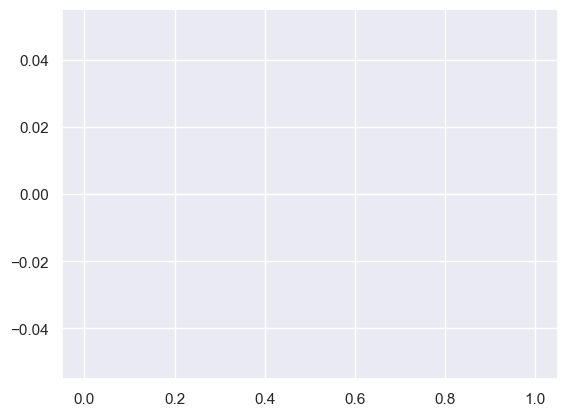

In [ ]:
import matplotlib.animation as animation

number_of_frames = 200

def update_hist(num, data):
    plt.cla()
    plt.hist(data[:num])

fig = plt.figure()
hist = plt.hist(mu_diff_samples[0])
animation = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(mu_diff_samples, ) )

from IPython.display import HTML
HTML(animation.to_jshtml())


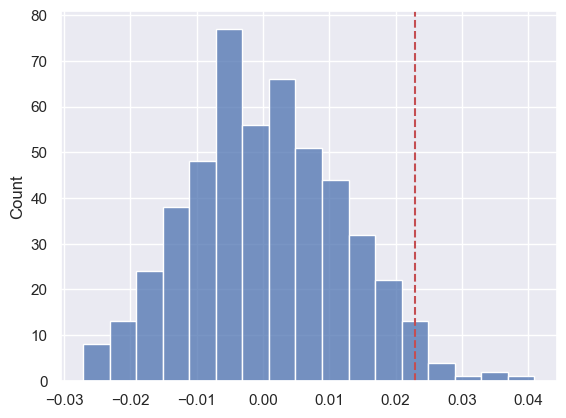

Avgerage Simulated Test Statistic: 0.0003
Initially Observed Test Statistic: 0.0229


In [ ]:
sns.histplot(mu_diff_samples)
plt.axvline(mu_diff, 0, 1, color='r', linestyle='--')
plt.show()
print('Avgerage Simulated Test Statistic:', f'{np.mean(mu_diff_samples):.4f}')
print('Initially Observed Test Statistic:', f'{mu_diff:.4f}')

In [ ]:
print('Results more extreme than observed:', sum([el >= mu_diff for el in mu_diff_samples]))
print('Total results:', len(mu_diff_samples))
p_value = sum([el > mu_diff for el in mu_diff_samples])/n
print('p-value:', sum([el >= mu_diff for el in mu_diff_samples]), '/', len(mu_diff_samples), '=', p_value*100, "%")

Results more extreme than observed: 10
Total results: 500
p-value: 10 / 500 = 2.0 %


In [ ]:

if p_value <= alpha: 
    print('H0 rejected: the observed result is statistically significant | p-value <= alpha')
else: 
    print('H0 accepted | the observed result is not statistically significant | p-value > alpha')

H0 rejected: the observed result is statistically significant | p-value <= alpha
